# Muti-task Rodent TBI segmentation
## Skull-stripping and ROI Segmentation
Author: Marcello De Salvo <br>

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Evaluation metrics](#metrics)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [1]:
import numpy as np
import os
import importlib
import pandas as pd
import time

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


# fix random seed for reproducibility
seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

Num GPUs Available:  1
2.10.0


# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
Problem: Skull-stripping and ROI semantic segmentation<br>
Each pixel in the image has to be assigned one of the following labels: <br>
- Background (label 0)
- Lesion (red, label 1)
- Ventricle contra (blue, label 3)
- Ventricle ipsi (light green, label 13)
- Third Ventricle (purple, label 21)

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1w (Flash)**
2. **T2w (Rare)**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [2]:
# PRE PROCESSING
import time

config ={
    'dataset_path': '..\dataset_roi',
    'input_shape': (80,80,80),
    'target_resolution': (0.1,0.1,0.1),
    'labels': [0,1,3,13,21], # 0: background, 1: lesion, 3: contra-ventricle, 13: ipsi-ventricle, 21: third ventricle
    'mapping': {0:0, 1:1, 3:2, 13:2, 21:3}, # 0: background, 1: ventricles, 2: cortex, 3: hippocampus -> 4 classes
    'num_classes': 4,
    'in_channels': 1,
    'batch_size': 8,
    'epochs': 300,
    'lr': 1e-3,
    'model_name': "mice_roi_unet" + "_ep" + str(500) + time.strftime("_%d-%m-%Y_%H-%M"),
    'validation_split': 0.2,
    'test_split': 0.1,
    'mice_sampling_rate': 3,
    'rats_sampling_rate': 0,
}

# 5. Data Visualization <a class='anchor' id='visual'></a> [↑](#top)

..\dataset_roi\t2w-C52-RARE\TBI_fm_19_50\Anat


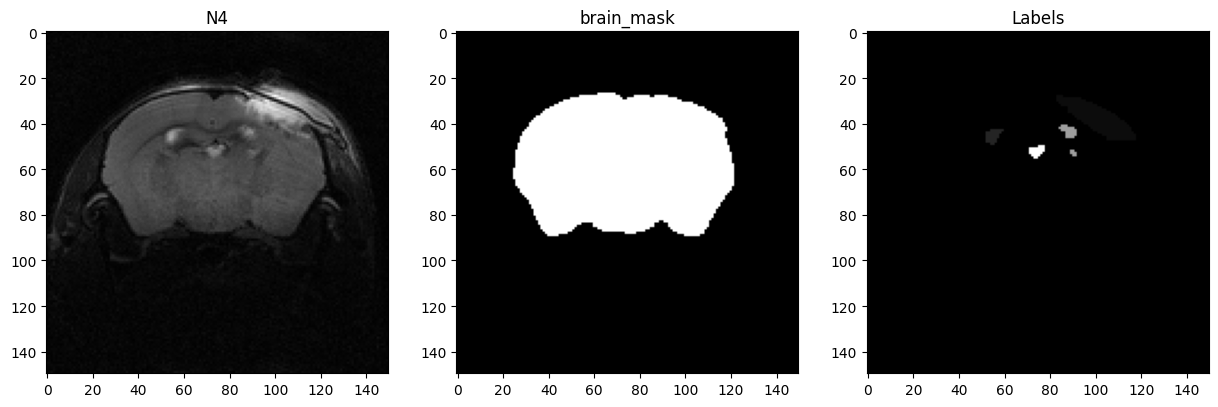

In [3]:
from utils.visualization import *
from utils.loader import load_data

# Modalities
modalities = ['N4', 'brain_mask', 'Labels']

# Patient
scan_type = 't2w-C52-RARE'
scan_id = 'TBI_fm_19_50'
scan_folder = os.path.join(config['dataset_path'], scan_type, scan_id, 'Anat')
print(scan_folder)

# Load data
img, data, file_paths = load_data(scan_folder, scan_id, modalities)

# Plot data
plot_data(data)

In [4]:
# Check unique values in the lesion mask
print(f"Unique values in the lesion mask: {np.unique(data['brain_mask'])}")

Unique values in the lesion mask: [0. 1.]


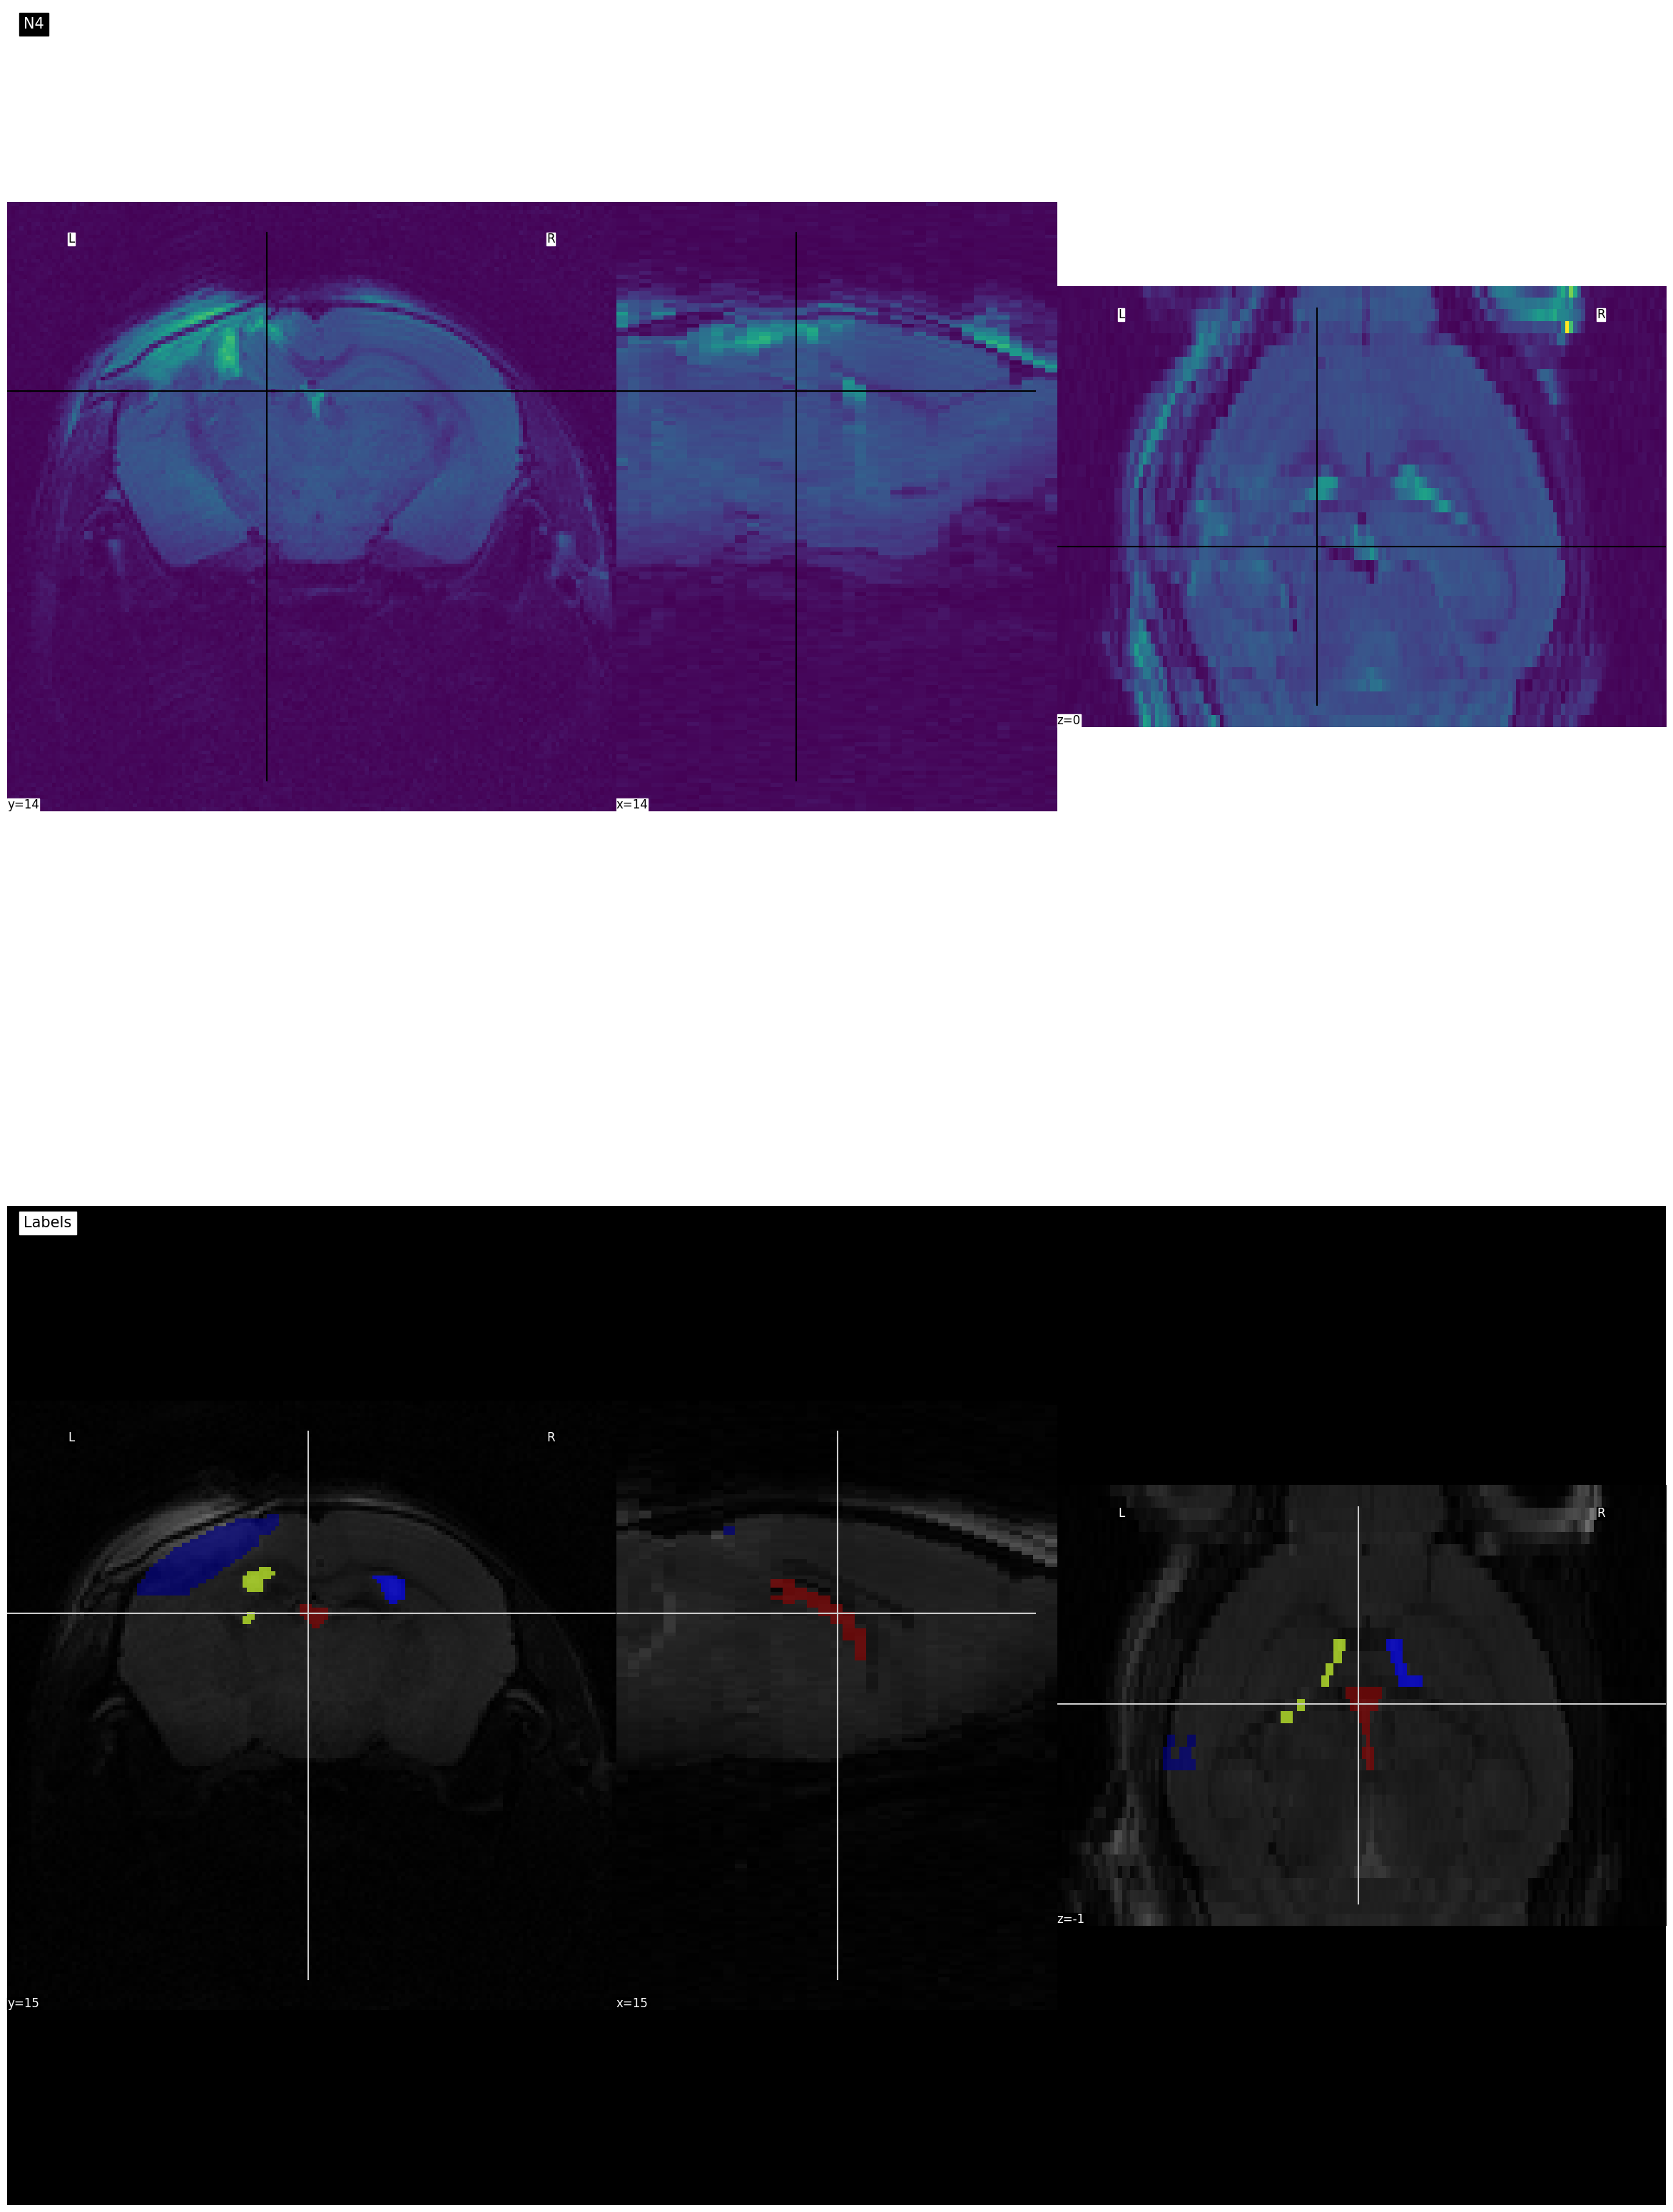

In [5]:
# Load data
niimg = nl.image.load_img(file_paths['N4'])
nimask = nl.image.load_img(file_paths['Labels'])
fig, axes = plt.subplots(nrows=2, figsize=(30, 40))

# Plot data
nlplt.plot_img(niimg, title='N4', axes=axes[0])
nlplt.plot_roi(nimask, title='Labels', bg_img=niimg, axes=axes[1], cmap='jet')
plt.show()

In [6]:
# Print matrix shape
print(f"Matrix shape: {data['N4'].shape}")

Matrix shape: (150, 150, 37)


# 6. Evaluation metrics <a class='anchor' id='loss'></a> [↑](#metrics)

In [7]:
from evaluation.metrics import *
from evaluation.losses import *

metrics = [accuracy_coefficient(), precision_coefficient(), sensitivity_coefficient(), specificity_coefficient(), dice_coefficient(), iou_coefficient(), volume_similarity_coefficient()]

# append to metric a class_dice_coef for each class
for i in range(config['num_classes']):
    metrics.append(dice_coefficient(class_index=i, exclude_background=False))

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [8]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import *

# Main Dataset
rodent_dataset = RodentDatasets(labels=config['labels'])

# Add all datasets
rodent_dataset.add_dataset(config['dataset_path'], 'T1w-C52-FLASH', sub_folder='Anat')
rodent_dataset.add_dataset(config['dataset_path'], 'T1w-CD1-FLASH', sub_folder='Anat')
rodent_dataset.add_dataset(config['dataset_path'], 'T2w-C52-RARE', sub_folder='Anat')
rodent_dataset.add_dataset(config['dataset_path'], 'T2w-Caen\\3 weeks', sub_folder='')

# Split data
train_and_test_ids = rodent_dataset.get_subjects_list()
print('Size of the dataset: ', len(train_and_test_ids))

# Splitting
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=config['validation_split']) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=config['test_split'])

Added 71 subjects from T1w-C52-FLASH
Added 15 subjects from T1w-CD1-FLASH
Added 26 subjects from T2w-C52-RARE
Added 30 subjects from T2w-Caen\3 weeks
Size of the dataset:  142


In [9]:
# Loading manually the rats of different time points
rats_dataset = RodentDatasets(labels=config['labels'])
rats_dataset.add_dataset(config['dataset_path'], 'T2w-RATS', sub_folder='Anat')

# Extract ids   
rats_ids = rats_dataset.get_subjects_list()

# Extract unique subjects by checking the first 4 characters of the second element of the tuple (e.g. RAT1_5w -> RAT1)
id_char_length = 4
rats_unique_ids = list(set([x[1][:id_char_length] for x in rats_ids]))

# Print
print('---- ')
print('Unique rats ids: ', rats_unique_ids)

# Select one rat at random for validation and use the rest for training
val_rat = np.random.choice(rats_unique_ids)
train_rats = [x for x in rats_unique_ids if x != val_rat]

# Extract thet time points of the selected rats
val_rat_id = [x for x in rats_ids if x[1][:id_char_length] == val_rat]
train_rat_ids = [x for x in rats_ids if x[1][:id_char_length] in train_rats]

# Print
print('---- ')
print('Validation rat id: ', val_rat, ' - time points: ', val_rat_id)
print('Training rat ids: ', train_rats, ' - time points: ', train_rat_ids)

# Merge the tuples in rats ids belonging to the the selected rats with the train and validation ids
train_ids = train_ids * config['mice_sampling_rate'] + train_rat_ids * config['rats_sampling_rate']
val_ids = val_ids * config['mice_sampling_rate'] + val_rat_id * config['rats_sampling_rate']
test_ids = test_ids * config['mice_sampling_rate']

# Print
print('---- ')
print('Training ids: ', train_ids)
print('Validation ids: ', val_ids)
print('Test ids: ', test_ids)

Added 20 subjects from T2w-RATS
---- 
Unique rats ids:  ['RAT2', 'RAT3', 'RAT1', 'RAT4', 'RAT5']
---- 
Validation rat id:  RAT2  - time points:  [('T2w-RATS', 'RAT2_14Days_CCI'), ('T2w-RATS', 'RAT2_30Days_CCI'), ('T2w-RATS', 'RAT2_60Days_CCI')]
Training rat ids:  ['RAT3', 'RAT1', 'RAT4', 'RAT5']  - time points:  [('T2w-RATS', 'RAT1_14Days_CCI'), ('T2w-RATS', 'RAT1_30Days_CCI'), ('T2w-RATS', 'RAT1_60Days_CCI'), ('T2w-RATS', 'RAT1_7Days_CCI'), ('T2w-RATS', 'RAT3_14Days_CCI'), ('T2w-RATS', 'RAT3_30Days_CCI'), ('T2w-RATS', 'RAT3_60Days_CCI'), ('T2w-RATS', 'RAT3_7Days_CCI'), ('T2w-RATS', 'RAT4_14Days_CCI'), ('T2w-RATS', 'RAT4_30Days_CCI'), ('T2w-RATS', 'RAT4_60Days_CCI'), ('T2w-RATS', 'RAT4_7Days_CCI'), ('T2w-RATS', 'RAT5_14Days_CCI'), ('T2w-RATS', 'RAT5_30Days_CCI'), ('T2w-RATS', 'RAT5_45Days_CCI'), ('T2w-RATS', 'RAT5_60Days_CCI'), ('T2w-RATS', 'RAT5_7Days_CCI')]
---- 
Training ids:  [('T2w-C52-RARE', 'TBI_gv_18_174'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1779'), ('T1w-CD1-FLASH', 'TBI_PTE_fm

In [10]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping, RandomAffine, GaussianBlur, Noise, Flip, Padder

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

augmented = Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    RandomAffine(rotation_range=[-5,5], scale_range=[0.95,1.05], probability=0.3),
    GaussianBlur([0,0.6], probability=0.3),
    Noise([0,0.05], probability=0.3),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    Padder(config['input_shape'], 'constant'),
    RandomCropping(config['input_shape'], mode='center', std=None),
    Flip(axis_list=[0], probability=0.5),
])

preprocessor =  Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    Padder(config['input_shape'], 'constant'),
    RandomCropping(config['input_shape'], mode='center', std=None),
    Flip(axis_list=[0], probability=0.5),
])

In [11]:
import importlib
import preprocessing.generator
importlib.reload(preprocessing.generator)
from preprocessing.generator import MultiTaskGenerator

# Datasets Initialization
training_generator = MultiTaskGenerator(train_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=augmented, config=config)
valid_generator = MultiTaskGenerator(val_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)
test_generator = MultiTaskGenerator(test_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)


print("Val IDs: ", val_ids)
print("Train IDs: ", train_ids)
print("Test IDs: ", test_ids)

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (80, 80, 80)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Val IDs:  [('T1w-C52-FLASH', 'TBI_MC_fp_22_150_5M'), ('T2w-C52-RARE', 'TBI_gv_20_68'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_166_5W'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_169_5M'), ('T2w-C52-RARE', 'TBI_gv_20_86'), ('T2w-Caen\\3 weeks', '20240917_100208_LS_TBI_J21_C2S4_170924_1_1'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_153_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_133_5M'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1809'), ('T2w-C52-RARE', 'TBI_gv_17_51'), ('T1w-CD1-FLASH'

## Sanity Check

Img shape:  (8, 80, 80, 80, 1)
Labels shape:  (8, 80, 80, 80, 4)
Brain mask shape: (8, 80, 80, 80, 1)
Max value in X:  7.863356248248913
Min value in X:  -1.0278712475661396
Unique values in Y:  [0. 1.]
Max value in Y:  1.0
Min value in Y:  0.0
Unique values in Y:  [0 1 2 3]


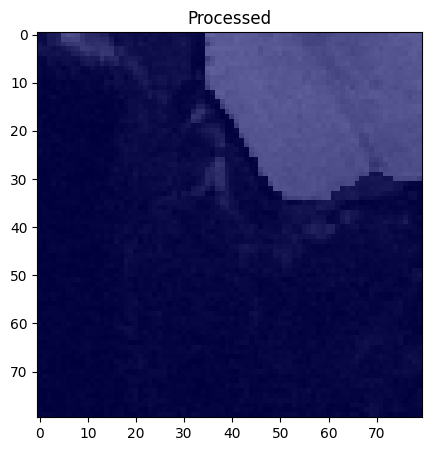

In [12]:
X,[Y,M]= training_generator.__getitem__(index=1) # Fetching the first batch  (X, [Seg, Mask])

print('Img shape: ', X.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, IN_CHANNELS) 
print('Labels shape: ', Y.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, NUM_CLASSES)
print('Brain mask shape:', M.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, 1)

# print max and min values in X
print("Max value in X: ", np.max(X))
print("Min value in X: ", np.min(X))

# Check if Y is one-hot encoded and has 4 different channels with label 1
print("Unique values in Y: ", np.unique(Y))

# print max and min values in Y
print("Max value in Y: ", np.max(Y))
print("Min value in Y: ", np.min(Y))

# Plot preview
sample=7
layer=config['input_shape'][2]//2

yhat=Y[sample]
yhat[yhat==-1]=0 # Convert all -1 to 0
yhat = np.argmax(yhat, axis=-1)

print("Unique values in Y: ", np.unique(yhat))
plt.figure(figsize=(15, 5))
plt.imshow(np.rot90(X[sample,:,:,layer,0], k=-1),cmap='gray')
plt.imshow(np.rot90(yhat[:,:,layer], k=-1), cmap='jet', alpha=0.6)
plt.imshow(np.rot90(M[sample,:,:,layer,0], k=-1), cmap='gray', alpha=0.2)
plt.title("Processed")
plt.show()

In [13]:
explore_3D_array_comparison(np.rot90(X[sample,:,:,:,0],k=-1),np.rot90(Y[sample,:,:,:,0],k=-1), axis=-1)

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

## Show Data Split Distribution

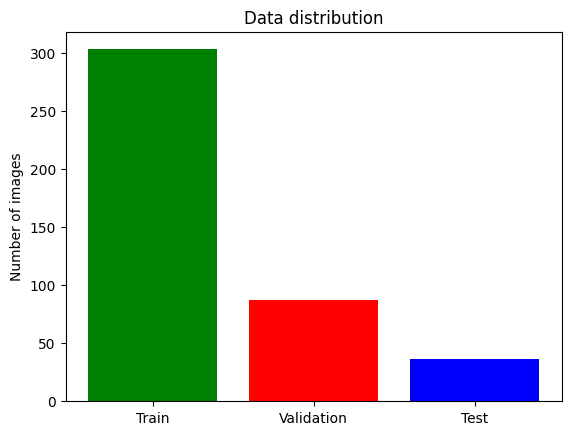

In [14]:
plt.bar(["Train","Validation", "Test"],
[len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red','blue'])

plt.ylabel('Number of images')
plt.title('Data distribution')

plt.show()

# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [15]:
from models.networks import *

# Example usage:
filters = [16, 32, 64, 128, 256]
model = mt_r_net_3d((None,None,None), config['in_channels'], config['num_classes'], filters, attention=True, residual=True)

## Overview

In [16]:
# Print summary of the model giving the input shape to function
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_10 (Conv3D)             (None, None, None,   448         ['input_1[0][0]']                
                                None, 16)                                                         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   64         ['conv3d_10[0][0]']              
 rmalization)                   None, 16)                                                     

## Callbacks

In [17]:
import datetime

csv_logger = CSVLogger('../results/'+config['model_name']+'/training.log', separator=',', append=False)
log_dir = "../results/"+config['model_name']+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "../results/"+config['model_name']+"/checkpoint/"

callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
        csv_logger
    ]

## Training

In [ ]:
steps = len(train_ids) // config['batch_size']
val_steps = len(val_ids) // config['batch_size']

roi_loss = diceCELoss(smooth=1e-5, batch_wise=True, gamma=0.8)
skullstrip_loss = diceBCELoss(alpha=0.6, smooth=1e-5, batch_wise=True)

losses = {
    'regions': roi_loss,
    'brain_mask': skullstrip_loss,
}
loss_weights = {
    'regions': 1,
    'brain_mask': 1,
}

tasks_metrics = {
    'regions': metrics,
    'brain_mask': dice_coefficient(class_index=0, exclude_background=False),
}

model.compile(loss=losses, optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), metrics=tasks_metrics, loss_weights=loss_weights)
history = model.fit(training_generator,epochs=config['epochs'], steps_per_epoch=steps, callbacks= callbacks, validation_data=valid_generator, validation_steps=val_steps)

Epoch 1/300
37/37 [==============================] - ETA: 0s - loss: 0.3896 - regions_loss: 0.1757 - brain_mask_loss: 0.1322 - regions_mean_accuracy: 0.9864 - regions_mean_precision: 0.2239 - regions_mean_sensitivity: 0.1173 - regions_mean_specificity: 0.9914 - regions_mean_dice: 0.1191 - regions_mean_iou: 0.0723 - regions_mean_volume_similarity: 0.4507 - regions_class_0_dice: 0.9687 - regions_class_1_dice: 0.2125 - regions_class_2_dice: 0.0922 - regions_class_3_dice: 0.0527 - brain_mask_class_0_dice: 0.8663

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 177s 3s/step - loss: 0.3896 - regions_loss: 0.1757 - brain_mask_loss: 0.1322 - regions_mean_accuracy: 0.9864 - regions_mean_precision: 0.2239 - regions_mean_sensitivity: 0.1173 - regions_mean_specificity: 0.9914 - regions_mean_dice: 0.1191 - regions_mean_iou: 0.0723 - regions_mean_volume_similarity: 0.4507 - regions_class_0_dice: 0.9687 - regions_class_1_dice: 0.2125 - regions_class_2_dice: 0.0922 - regions_class_3_dice: 0.0527 - brain_mask_class_0_dice: 0.8663 - val_loss: 1.3249 - val_regions_loss: 0.2051 - val_brain_mask_loss: 1.0395 - val_regions_mean_accuracy: 0.9918 - val_regions_mean_precision: 0.0275 - val_regions_mean_sensitivity: 0.0011 - val_regions_mean_specificity: 0.9997 - val_regions_mean_dice: 0.0020 - val_regions_mean_iou: 9.7976e-04 - val_regions_mean_volume_similarity: 0.2035 - val_regions_class_0_dice: 0.9875 - val_regions_class_1_dice: 0.0028 - val_regions_class_2_dice: 0.0023 - val_regions_class_3_dice: 8.0161e-04 - val_brai

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 115s 3s/step - loss: 0.2854 - regions_loss: 0.1253 - brain_mask_loss: 0.0811 - regions_mean_accuracy: 0.9936 - regions_mean_precision: 0.4765 - regions_mean_sensitivity: 0.2901 - regions_mean_specificity: 0.9978 - regions_mean_dice: 0.3157 - regions_mean_iou: 0.1980 - regions_mean_volume_similarity: 0.6397 - regions_class_0_dice: 0.9914 - regions_class_1_dice: 0.3665 - regions_class_2_dice: 0.2996 - regions_class_3_dice: 0.2811 - brain_mask_class_0_dice: 0.9235 - val_loss: 0.3689 - val_regions_loss: 0.1394 - val_brain_mask_loss: 0.1518 - val_regions_mean_accuracy: 0.9913 - val_regions_mean_precision: 0.3917 - val_regions_mean_sensitivity: 0.2556 - val_regions_mean_specificity: 0.9958 - val_regions_mean_dice: 0.2835 - val_regions_mean_iou: 0.1711 - val_regions_mean_volume_similarity: 0.7062 - val_regions_class_0_dice: 0.9873 - val_regions_class_1_dice: 0.3890 - val_regions_class_2_dice: 0.3230 - val_regions_class_3_dice: 0.1384 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.2284 - regions_loss: 0.0974 - brain_mask_loss: 0.0542 - regions_mean_accuracy: 0.9942 - regions_mean_precision: 0.5857 - regions_mean_sensitivity: 0.4493 - regions_mean_specificity: 0.9977 - regions_mean_dice: 0.4783 - regions_mean_iou: 0.3219 - regions_mean_volume_similarity: 0.7717 - regions_class_0_dice: 0.9921 - regions_class_1_dice: 0.5273 - regions_class_2_dice: 0.4518 - regions_class_3_dice: 0.4559 - brain_mask_class_0_dice: 0.9499 - val_loss: 0.2373 - val_regions_loss: 0.1036 - val_brain_mask_loss: 0.0579 - val_regions_mean_accuracy: 0.9948 - val_regions_mean_precision: 0.7486 - val_regions_mean_sensitivity: 0.3525 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.4236 - val_regions_mean_iou: 0.2865 - val_regions_mean_volume_similarity: 0.6039 - val_regions_class_0_dice: 0.9930 - val_regions_class_1_dice: 0.5206 - val_regions_class_2_dice: 0.2081 - val_regions_class_3_dice: 0.5422 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.1926 - regions_loss: 0.0780 - brain_mask_loss: 0.0397 - regions_mean_accuracy: 0.9954 - regions_mean_precision: 0.6595 - regions_mean_sensitivity: 0.5733 - regions_mean_specificity: 0.9981 - regions_mean_dice: 0.5840 - regions_mean_iou: 0.4204 - regions_mean_volume_similarity: 0.8139 - regions_class_0_dice: 0.9938 - regions_class_1_dice: 0.6327 - regions_class_2_dice: 0.5217 - regions_class_3_dice: 0.5977 - brain_mask_class_0_dice: 0.9645 - val_loss: 0.2122 - val_regions_loss: 0.0979 - val_brain_mask_loss: 0.0404 - val_regions_mean_accuracy: 0.9896 - val_regions_mean_precision: 0.5076 - val_regions_mean_sensitivity: 0.7384 - val_regions_mean_specificity: 0.9908 - val_regions_mean_dice: 0.5778 - val_regions_mean_iou: 0.4082 - val_regions_mean_volume_similarity: 0.7676 - val_regions_class_0_dice: 0.9845 - val_regions_class_1_dice: 0.5731 - val_regions_class_2_dice: 0.5819 - val_regions_class_3_dice: 0.5783 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.1671 - regions_loss: 0.0628 - brain_mask_loss: 0.0313 - regions_mean_accuracy: 0.9963 - regions_mean_precision: 0.7203 - regions_mean_sensitivity: 0.6530 - regions_mean_specificity: 0.9984 - regions_mean_dice: 0.6685 - regions_mean_iou: 0.5073 - regions_mean_volume_similarity: 0.8738 - regions_class_0_dice: 0.9950 - regions_class_1_dice: 0.7092 - regions_class_2_dice: 0.6186 - regions_class_3_dice: 0.6777 - brain_mask_class_0_dice: 0.9720 - val_loss: 0.1891 - val_regions_loss: 0.0655 - val_brain_mask_loss: 0.0516 - val_regions_mean_accuracy: 0.9959 - val_regions_mean_precision: 0.6279 - val_regions_mean_sensitivity: 0.7405 - val_regions_mean_specificity: 0.9978 - val_regions_mean_dice: 0.6615 - val_regions_mean_iou: 0.5028 - val_regions_mean_volume_similarity: 0.8628 - val_regions_class_0_dice: 0.9944 - val_regions_class_1_dice: 0.7706 - val_regions_class_2_dice: 0.6315 - val_regions_class_3_dice: 0.5825 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 114s 3s/step - loss: 0.1547 - regions_loss: 0.0529 - brain_mask_loss: 0.0306 - regions_mean_accuracy: 0.9967 - regions_mean_precision: 0.7557 - regions_mean_sensitivity: 0.7108 - regions_mean_specificity: 0.9986 - regions_mean_dice: 0.7230 - regions_mean_iou: 0.5716 - regions_mean_volume_similarity: 0.9067 - regions_class_0_dice: 0.9956 - regions_class_1_dice: 0.7787 - regions_class_2_dice: 0.6633 - regions_class_3_dice: 0.7271 - brain_mask_class_0_dice: 0.9728 - val_loss: 0.1702 - val_regions_loss: 0.0602 - val_brain_mask_loss: 0.0399 - val_regions_mean_accuracy: 0.9955 - val_regions_mean_precision: 0.6450 - val_regions_mean_sensitivity: 0.8043 - val_regions_mean_specificity: 0.9971 - val_regions_mean_dice: 0.7123 - val_regions_mean_iou: 0.5566 - val_regions_mean_volume_similarity: 0.8865 - val_regions_class_0_dice: 0.9937 - val_regions_class_1_dice: 0.7583 - val_regions_class_2_dice: 0.6711 - val_regions_class_3_dice: 0.7073 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 114s 3s/step - loss: 0.1579 - regions_loss: 0.0569 - brain_mask_loss: 0.0315 - regions_mean_accuracy: 0.9967 - regions_mean_precision: 0.7421 - regions_mean_sensitivity: 0.6921 - regions_mean_specificity: 0.9986 - regions_mean_dice: 0.6969 - regions_mean_iou: 0.5440 - regions_mean_volume_similarity: 0.8730 - regions_class_0_dice: 0.9956 - regions_class_1_dice: 0.7415 - regions_class_2_dice: 0.6262 - regions_class_3_dice: 0.7229 - brain_mask_class_0_dice: 0.9720 - val_loss: 0.1469 - val_regions_loss: 0.0480 - val_brain_mask_loss: 0.0300 - val_regions_mean_accuracy: 0.9970 - val_regions_mean_precision: 0.7629 - val_regions_mean_sensitivity: 0.7447 - val_regions_mean_specificity: 0.9986 - val_regions_mean_dice: 0.7489 - val_regions_mean_iou: 0.6033 - val_regions_mean_volume_similarity: 0.9382 - val_regions_class_0_dice: 0.9961 - val_regions_class_1_dice: 0.7947 - val_regions_class_2_dice: 0.6984 - val_regions_class_3_dice: 0.7537 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.1433 - regions_loss: 0.0484 - brain_mask_loss: 0.0267 - regions_mean_accuracy: 0.9972 - regions_mean_precision: 0.7719 - regions_mean_sensitivity: 0.7286 - regions_mean_specificity: 0.9988 - regions_mean_dice: 0.7411 - regions_mean_iou: 0.5944 - regions_mean_volume_similarity: 0.9156 - regions_class_0_dice: 0.9963 - regions_class_1_dice: 0.7605 - regions_class_2_dice: 0.7007 - regions_class_3_dice: 0.7621 - brain_mask_class_0_dice: 0.9756 - val_loss: 0.1355 - val_regions_loss: 0.0414 - val_brain_mask_loss: 0.0267 - val_regions_mean_accuracy: 0.9972 - val_regions_mean_precision: 0.8536 - val_regions_mean_sensitivity: 0.7274 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.7829 - val_regions_mean_iou: 0.6458 - val_regions_mean_volume_similarity: 0.9163 - val_regions_class_0_dice: 0.9962 - val_regions_class_1_dice: 0.7970 - val_regions_class_2_dice: 0.7520 - val_regions_class_3_dice: 0.7998 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 110s 3s/step - loss: 0.1332 - regions_loss: 0.0435 - brain_mask_loss: 0.0245 - regions_mean_accuracy: 0.9972 - regions_mean_precision: 0.7995 - regions_mean_sensitivity: 0.7626 - regions_mean_specificity: 0.9988 - regions_mean_dice: 0.7720 - regions_mean_iou: 0.6344 - regions_mean_volume_similarity: 0.9165 - regions_class_0_dice: 0.9963 - regions_class_1_dice: 0.7894 - regions_class_2_dice: 0.7367 - regions_class_3_dice: 0.7900 - brain_mask_class_0_dice: 0.9776 - val_loss: 0.1280 - val_regions_loss: 0.0373 - val_brain_mask_loss: 0.0263 - val_regions_mean_accuracy: 0.9973 - val_regions_mean_precision: 0.8294 - val_regions_mean_sensitivity: 0.8010 - val_regions_mean_specificity: 0.9985 - val_regions_mean_dice: 0.8093 - val_regions_mean_iou: 0.6826 - val_regions_mean_volume_similarity: 0.9355 - val_regions_class_0_dice: 0.9965 - val_regions_class_1_dice: 0.8334 - val_regions_class_2_dice: 0.7665 - val_regions_class_3_dice: 0.8281 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.1248 - regions_loss: 0.0384 - brain_mask_loss: 0.0227 - regions_mean_accuracy: 0.9976 - regions_mean_precision: 0.8164 - regions_mean_sensitivity: 0.7881 - regions_mean_specificity: 0.9989 - regions_mean_dice: 0.7980 - regions_mean_iou: 0.6670 - regions_mean_volume_similarity: 0.9414 - regions_class_0_dice: 0.9968 - regions_class_1_dice: 0.8354 - regions_class_2_dice: 0.7574 - regions_class_3_dice: 0.8010 - brain_mask_class_0_dice: 0.9795 - val_loss: 0.1242 - val_regions_loss: 0.0345 - val_brain_mask_loss: 0.0270 - val_regions_mean_accuracy: 0.9978 - val_regions_mean_precision: 0.8397 - val_regions_mean_sensitivity: 0.8117 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8230 - val_regions_mean_iou: 0.7014 - val_regions_mean_volume_similarity: 0.9567 - val_regions_class_0_dice: 0.9972 - val_regions_class_1_dice: 0.8481 - val_regions_class_2_dice: 0.7880 - val_regions_class_3_dice: 0.8328 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 114s 3s/step - loss: 0.1178 - regions_loss: 0.0363 - brain_mask_loss: 0.0209 - regions_mean_accuracy: 0.9978 - regions_mean_precision: 0.8296 - regions_mean_sensitivity: 0.7972 - regions_mean_specificity: 0.9990 - regions_mean_dice: 0.8085 - regions_mean_iou: 0.6813 - regions_mean_volume_similarity: 0.9377 - regions_class_0_dice: 0.9971 - regions_class_1_dice: 0.8403 - regions_class_2_dice: 0.7700 - regions_class_3_dice: 0.8152 - brain_mask_class_0_dice: 0.9811 - val_loss: 0.1205 - val_regions_loss: 0.0365 - val_brain_mask_loss: 0.0243 - val_regions_mean_accuracy: 0.9973 - val_regions_mean_precision: 0.8596 - val_regions_mean_sensitivity: 0.7729 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.8119 - val_regions_mean_iou: 0.6855 - val_regions_mean_volume_similarity: 0.9377 - val_regions_class_0_dice: 0.9965 - val_regions_class_1_dice: 0.8315 - val_regions_class_2_dice: 0.7895 - val_regions_class_3_dice: 0.8148 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.1079 - regions_loss: 0.0312 - brain_mask_loss: 0.0193 - regions_mean_accuracy: 0.9981 - regions_mean_precision: 0.8473 - regions_mean_sensitivity: 0.8266 - regions_mean_specificity: 0.9991 - regions_mean_dice: 0.8347 - regions_mean_iou: 0.7191 - regions_mean_volume_similarity: 0.9591 - regions_class_0_dice: 0.9975 - regions_class_1_dice: 0.8744 - regions_class_2_dice: 0.8041 - regions_class_3_dice: 0.8257 - brain_mask_class_0_dice: 0.9826 - val_loss: 0.1158 - val_regions_loss: 0.0325 - val_brain_mask_loss: 0.0268 - val_regions_mean_accuracy: 0.9975 - val_regions_mean_precision: 0.8775 - val_regions_mean_sensitivity: 0.8006 - val_regions_mean_specificity: 0.9989 - val_regions_mean_dice: 0.8347 - val_regions_mean_iou: 0.7191 - val_regions_mean_volume_similarity: 0.9396 - val_regions_class_0_dice: 0.9969 - val_regions_class_1_dice: 0.8652 - val_regions_class_2_dice: 0.8003 - val_regions_class_3_dice: 0.8386 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.1055 - regions_loss: 0.0307 - brain_mask_loss: 0.0189 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.8519 - regions_mean_sensitivity: 0.8279 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8363 - regions_mean_iou: 0.7207 - regions_mean_volume_similarity: 0.9466 - regions_class_0_dice: 0.9976 - regions_class_1_dice: 0.8728 - regions_class_2_dice: 0.8106 - regions_class_3_dice: 0.8256 - brain_mask_class_0_dice: 0.9827 - val_loss: 0.1104 - val_regions_loss: 0.0337 - val_brain_mask_loss: 0.0215 - val_regions_mean_accuracy: 0.9975 - val_regions_mean_precision: 0.8191 - val_regions_mean_sensitivity: 0.8412 - val_regions_mean_specificity: 0.9984 - val_regions_mean_dice: 0.8263 - val_regions_mean_iou: 0.7060 - val_regions_mean_volume_similarity: 0.9384 - val_regions_class_0_dice: 0.9967 - val_regions_class_1_dice: 0.8475 - val_regions_class_2_dice: 0.8075 - val_regions_class_3_dice: 0.8241 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.1043 - regions_loss: 0.0308 - brain_mask_loss: 0.0189 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.8490 - regions_mean_sensitivity: 0.8272 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8352 - regions_mean_iou: 0.7190 - regions_mean_volume_similarity: 0.9528 - regions_class_0_dice: 0.9976 - regions_class_1_dice: 0.8643 - regions_class_2_dice: 0.8074 - regions_class_3_dice: 0.8339 - brain_mask_class_0_dice: 0.9825 - val_loss: 0.1033 - val_regions_loss: 0.0274 - val_brain_mask_loss: 0.0219 - val_regions_mean_accuracy: 0.9980 - val_regions_mean_precision: 0.8773 - val_regions_mean_sensitivity: 0.8440 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.8590 - val_regions_mean_iou: 0.7549 - val_regions_mean_volume_similarity: 0.9669 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.8816 - val_regions_class_2_dice: 0.8301 - val_regions_class_3_dice: 0.8655 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 111s 3s/step - loss: 0.1042 - regions_loss: 0.0314 - brain_mask_loss: 0.0193 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.8473 - regions_mean_sensitivity: 0.8254 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8321 - regions_mean_iou: 0.7157 - regions_mean_volume_similarity: 0.9456 - regions_class_0_dice: 0.9976 - regions_class_1_dice: 0.8765 - regions_class_2_dice: 0.7946 - regions_class_3_dice: 0.8253 - brain_mask_class_0_dice: 0.9822 - val_loss: 0.1028 - val_regions_loss: 0.0278 - val_brain_mask_loss: 0.0222 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.8474 - val_regions_mean_sensitivity: 0.8599 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.8516 - val_regions_mean_iou: 0.7438 - val_regions_mean_volume_similarity: 0.9571 - val_regions_class_0_dice: 0.9979 - val_regions_class_1_dice: 0.8774 - val_regions_class_2_dice: 0.8294 - val_regions_class_3_dice: 0.8480 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 124s 3s/step - loss: 0.0967 - regions_loss: 0.0284 - brain_mask_loss: 0.0183 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.8592 - regions_mean_sensitivity: 0.8433 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8482 - regions_mean_iou: 0.7392 - regions_mean_volume_similarity: 0.9552 - regions_class_0_dice: 0.9977 - regions_class_1_dice: 0.8898 - regions_class_2_dice: 0.8242 - regions_class_3_dice: 0.8306 - brain_mask_class_0_dice: 0.9833 - val_loss: 0.0944 - val_regions_loss: 0.0260 - val_brain_mask_loss: 0.0190 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.8908 - val_regions_mean_sensitivity: 0.8370 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8611 - val_regions_mean_iou: 0.7587 - val_regions_mean_volume_similarity: 0.9587 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.8966 - val_regions_class_2_dice: 0.8258 - val_regions_class_3_dice: 0.8610 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 120s 3s/step - loss: 0.0918 - regions_loss: 0.0282 - brain_mask_loss: 0.0176 - regions_mean_accuracy: 0.9983 - regions_mean_precision: 0.8591 - regions_mean_sensitivity: 0.8426 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8486 - regions_mean_iou: 0.7397 - regions_mean_volume_similarity: 0.9608 - regions_class_0_dice: 0.9978 - regions_class_1_dice: 0.8891 - regions_class_2_dice: 0.8142 - regions_class_3_dice: 0.8427 - brain_mask_class_0_dice: 0.9839 - val_loss: 0.0935 - val_regions_loss: 0.0265 - val_brain_mask_loss: 0.0216 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.8704 - val_regions_mean_sensitivity: 0.8493 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8587 - val_regions_mean_iou: 0.7537 - val_regions_mean_volume_similarity: 0.9705 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.8785 - val_regions_class_2_dice: 0.8353 - val_regions_class_3_dice: 0.8624 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 120s 3s/step - loss: 0.0891 - regions_loss: 0.0276 - brain_mask_loss: 0.0178 - regions_mean_accuracy: 0.9983 - regions_mean_precision: 0.8626 - regions_mean_sensitivity: 0.8458 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8521 - regions_mean_iou: 0.7442 - regions_mean_volume_similarity: 0.9624 - regions_class_0_dice: 0.9978 - regions_class_1_dice: 0.8841 - regions_class_2_dice: 0.8309 - regions_class_3_dice: 0.8413 - brain_mask_class_0_dice: 0.9836 - val_loss: 0.0934 - val_regions_loss: 0.0281 - val_brain_mask_loss: 0.0223 - val_regions_mean_accuracy: 0.9982 - val_regions_mean_precision: 0.8422 - val_regions_mean_sensitivity: 0.8662 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8515 - val_regions_mean_iou: 0.7425 - val_regions_mean_volume_similarity: 0.9541 - val_regions_class_0_dice: 0.9977 - val_regions_class_1_dice: 0.8673 - val_regions_class_2_dice: 0.8463 - val_regions_class_3_dice: 0.8408 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 119s 3s/step - loss: 0.0850 - regions_loss: 0.0253 - brain_mask_loss: 0.0171 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8734 - regions_mean_sensitivity: 0.8574 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8632 - regions_mean_iou: 0.7617 - regions_mean_volume_similarity: 0.9616 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.8980 - regions_class_2_dice: 0.8436 - regions_class_3_dice: 0.8479 - brain_mask_class_0_dice: 0.9842 - val_loss: 0.0896 - val_regions_loss: 0.0273 - val_brain_mask_loss: 0.0202 - val_regions_mean_accuracy: 0.9980 - val_regions_mean_precision: 0.8602 - val_regions_mean_sensitivity: 0.8608 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.8587 - val_regions_mean_iou: 0.7539 - val_regions_mean_volume_similarity: 0.9626 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.8822 - val_regions_class_2_dice: 0.8391 - val_regions_class_3_dice: 0.8548 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 120s 3s/step - loss: 0.0863 - regions_loss: 0.0272 - brain_mask_loss: 0.0174 - regions_mean_accuracy: 0.9984 - regions_mean_precision: 0.8657 - regions_mean_sensitivity: 0.8466 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8539 - regions_mean_iou: 0.7478 - regions_mean_volume_similarity: 0.9605 - regions_class_0_dice: 0.9979 - regions_class_1_dice: 0.8860 - regions_class_2_dice: 0.8315 - regions_class_3_dice: 0.8443 - brain_mask_class_0_dice: 0.9838 - val_loss: 0.0869 - val_regions_loss: 0.0252 - val_brain_mask_loss: 0.0204 - val_regions_mean_accuracy: 0.9981 - val_regions_mean_precision: 0.8653 - val_regions_mean_sensitivity: 0.8778 - val_regions_mean_specificity: 0.9988 - val_regions_mean_dice: 0.8709 - val_regions_mean_iou: 0.7729 - val_regions_mean_volume_similarity: 0.9781 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.9025 - val_regions_class_2_dice: 0.8458 - val_regions_class_3_dice: 0.8645 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.0830 - regions_loss: 0.0250 - brain_mask_loss: 0.0172 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8747 - regions_mean_sensitivity: 0.8591 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8653 - regions_mean_iou: 0.7645 - regions_mean_volume_similarity: 0.9664 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.8957 - regions_class_2_dice: 0.8452 - regions_class_3_dice: 0.8551 - brain_mask_class_0_dice: 0.9838 - val_loss: 0.0843 - val_regions_loss: 0.0244 - val_brain_mask_loss: 0.0196 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.8828 - val_regions_mean_sensitivity: 0.8656 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.8730 - val_regions_mean_iou: 0.7760 - val_regions_mean_volume_similarity: 0.9696 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8867 - val_regions_class_2_dice: 0.8578 - val_regions_class_3_dice: 0.8746 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.0809 - regions_loss: 0.0249 - brain_mask_loss: 0.0169 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8742 - regions_mean_sensitivity: 0.8635 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8672 - regions_mean_iou: 0.7676 - regions_mean_volume_similarity: 0.9666 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9019 - regions_class_2_dice: 0.8500 - regions_class_3_dice: 0.8496 - brain_mask_class_0_dice: 0.9847 - val_loss: 0.0837 - val_regions_loss: 0.0245 - val_brain_mask_loss: 0.0207 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.8963 - val_regions_mean_sensitivity: 0.8509 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8720 - val_regions_mean_iou: 0.7748 - val_regions_mean_volume_similarity: 0.9654 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8995 - val_regions_class_2_dice: 0.8482 - val_regions_class_3_dice: 0.8684 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 114s 3s/step - loss: 0.0795 - regions_loss: 0.0244 - brain_mask_loss: 0.0171 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8779 - regions_mean_sensitivity: 0.8636 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8689 - regions_mean_iou: 0.7703 - regions_mean_volume_similarity: 0.9662 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9018 - regions_class_2_dice: 0.8537 - regions_class_3_dice: 0.8513 - brain_mask_class_0_dice: 0.9842 - val_loss: 0.0833 - val_regions_loss: 0.0251 - val_brain_mask_loss: 0.0205 - val_regions_mean_accuracy: 0.9982 - val_regions_mean_precision: 0.8832 - val_regions_mean_sensitivity: 0.8621 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8712 - val_regions_mean_iou: 0.7732 - val_regions_mean_volume_similarity: 0.9672 - val_regions_class_0_dice: 0.9976 - val_regions_class_1_dice: 0.8820 - val_regions_class_2_dice: 0.8556 - val_regions_class_3_dice: 0.8760 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.0779 - regions_loss: 0.0255 - brain_mask_loss: 0.0167 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8706 - regions_mean_sensitivity: 0.8582 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8621 - regions_mean_iou: 0.7605 - regions_mean_volume_similarity: 0.9618 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9023 - regions_class_2_dice: 0.8312 - regions_class_3_dice: 0.8527 - brain_mask_class_0_dice: 0.9848 - val_loss: 0.0829 - val_regions_loss: 0.0260 - val_brain_mask_loss: 0.0215 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.8614 - val_regions_mean_sensitivity: 0.8709 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.8638 - val_regions_mean_iou: 0.7626 - val_regions_mean_volume_similarity: 0.9553 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8953 - val_regions_class_2_dice: 0.8338 - val_regions_class_3_dice: 0.8622 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.0776 - regions_loss: 0.0253 - brain_mask_loss: 0.0172 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.8736 - regions_mean_sensitivity: 0.8567 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8628 - regions_mean_iou: 0.7617 - regions_mean_volume_similarity: 0.9623 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.8996 - regions_class_2_dice: 0.8302 - regions_class_3_dice: 0.8587 - brain_mask_class_0_dice: 0.9841 - val_loss: 0.0822 - val_regions_loss: 0.0265 - val_brain_mask_loss: 0.0210 - val_regions_mean_accuracy: 0.9981 - val_regions_mean_precision: 0.8909 - val_regions_mean_sensitivity: 0.8398 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8638 - val_regions_mean_iou: 0.7619 - val_regions_mean_volume_similarity: 0.9647 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.8806 - val_regions_class_2_dice: 0.8464 - val_regions_class_3_dice: 0.8643 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0748 - regions_loss: 0.0246 - brain_mask_loss: 0.0159 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8766 - regions_mean_sensitivity: 0.8658 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8679 - regions_mean_iou: 0.7695 - regions_mean_volume_similarity: 0.9578 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9016 - regions_class_2_dice: 0.8450 - regions_class_3_dice: 0.8570 - brain_mask_class_0_dice: 0.9852 - val_loss: 0.0804 - val_regions_loss: 0.0260 - val_brain_mask_loss: 0.0204 - val_regions_mean_accuracy: 0.9982 - val_regions_mean_precision: 0.8592 - val_regions_mean_sensitivity: 0.8696 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.8634 - val_regions_mean_iou: 0.7612 - val_regions_mean_volume_similarity: 0.9719 - val_regions_class_0_dice: 0.9977 - val_regions_class_1_dice: 0.8815 - val_regions_class_2_dice: 0.8377 - val_regions_class_3_dice: 0.8710 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 112s 3s/step - loss: 0.0760 - regions_loss: 0.0241 - brain_mask_loss: 0.0179 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8801 - regions_mean_sensitivity: 0.8641 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8707 - regions_mean_iou: 0.7729 - regions_mean_volume_similarity: 0.9692 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.8968 - regions_class_2_dice: 0.8512 - regions_class_3_dice: 0.8639 - brain_mask_class_0_dice: 0.9832 - val_loss: 0.0802 - val_regions_loss: 0.0260 - val_brain_mask_loss: 0.0205 - val_regions_mean_accuracy: 0.9981 - val_regions_mean_precision: 0.8837 - val_regions_mean_sensitivity: 0.8549 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.8672 - val_regions_mean_iou: 0.7673 - val_regions_mean_volume_similarity: 0.9640 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.8799 - val_regions_class_2_dice: 0.8550 - val_regions_class_3_dice: 0.8668 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 114s 3s/step - loss: 0.0735 - regions_loss: 0.0233 - brain_mask_loss: 0.0168 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.8827 - regions_mean_sensitivity: 0.8699 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8745 - regions_mean_iou: 0.7789 - regions_mean_volume_similarity: 0.9646 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9116 - regions_class_2_dice: 0.8531 - regions_class_3_dice: 0.8587 - brain_mask_class_0_dice: 0.9844 - val_loss: 0.0796 - val_regions_loss: 0.0281 - val_brain_mask_loss: 0.0184 - val_regions_mean_accuracy: 0.9979 - val_regions_mean_precision: 0.9116 - val_regions_mean_sensitivity: 0.8044 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8524 - val_regions_mean_iou: 0.7459 - val_regions_mean_volume_similarity: 0.9351 - val_regions_class_0_dice: 0.9973 - val_regions_class_1_dice: 0.8817 - val_regions_class_2_dice: 0.8158 - val_regions_class_3_dice: 0.8599 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0729 - regions_loss: 0.0232 - brain_mask_loss: 0.0167 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.8845 - regions_mean_sensitivity: 0.8701 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8759 - regions_mean_iou: 0.7812 - regions_mean_volume_similarity: 0.9724 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.9079 - regions_class_2_dice: 0.8541 - regions_class_3_dice: 0.8658 - brain_mask_class_0_dice: 0.9846 - val_loss: 0.0755 - val_regions_loss: 0.0237 - val_brain_mask_loss: 0.0194 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.9160 - val_regions_mean_sensitivity: 0.8457 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8784 - val_regions_mean_iou: 0.7847 - val_regions_mean_volume_similarity: 0.9584 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8910 - val_regions_class_2_dice: 0.8637 - val_regions_class_3_dice: 0.8805 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 146s 4s/step - loss: 0.0720 - regions_loss: 0.0241 - brain_mask_loss: 0.0165 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.8753 - regions_mean_sensitivity: 0.8634 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8679 - regions_mean_iou: 0.7687 - regions_mean_volume_similarity: 0.9677 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.9021 - regions_class_2_dice: 0.8476 - regions_class_3_dice: 0.8539 - brain_mask_class_0_dice: 0.9844 - val_loss: 0.0755 - val_regions_loss: 0.0227 - val_brain_mask_loss: 0.0218 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.8813 - val_regions_mean_sensitivity: 0.8836 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8815 - val_regions_mean_iou: 0.7896 - val_regions_mean_volume_similarity: 0.9721 - val_regions_class_0_dice: 0.9979 - val_regions_class_1_dice: 0.8992 - val_regions_class_2_dice: 0.8709 - val_regions_class_3_dice: 0.8744 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 116s 3s/step - loss: 0.0683 - regions_loss: 0.0225 - brain_mask_loss: 0.0166 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.8858 - regions_mean_sensitivity: 0.8728 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8782 - regions_mean_iou: 0.7848 - regions_mean_volume_similarity: 0.9722 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.9119 - regions_class_2_dice: 0.8552 - regions_class_3_dice: 0.8675 - brain_mask_class_0_dice: 0.9844 - val_loss: 0.0710 - val_regions_loss: 0.0236 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.8994 - val_regions_mean_sensitivity: 0.8583 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8773 - val_regions_mean_iou: 0.7832 - val_regions_mean_volume_similarity: 0.9689 - val_regions_class_0_dice: 0.9979 - val_regions_class_1_dice: 0.9003 - val_regions_class_2_dice: 0.8570 - val_regions_class_3_dice: 0.8746 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0697 - regions_loss: 0.0232 - brain_mask_loss: 0.0165 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.8814 - regions_mean_sensitivity: 0.8720 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8754 - regions_mean_iou: 0.7801 - regions_mean_volume_similarity: 0.9712 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9085 - regions_class_2_dice: 0.8571 - regions_class_3_dice: 0.8606 - brain_mask_class_0_dice: 0.9847 - val_loss: 0.0705 - val_regions_loss: 0.0229 - val_brain_mask_loss: 0.0181 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.8912 - val_regions_mean_sensitivity: 0.8787 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8838 - val_regions_mean_iou: 0.7927 - val_regions_mean_volume_similarity: 0.9727 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8993 - val_regions_class_2_dice: 0.8659 - val_regions_class_3_dice: 0.8862 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0661 - regions_loss: 0.0221 - brain_mask_loss: 0.0166 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.8895 - regions_mean_sensitivity: 0.8756 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8815 - regions_mean_iou: 0.7900 - regions_mean_volume_similarity: 0.9724 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9131 - regions_class_2_dice: 0.8622 - regions_class_3_dice: 0.8691 - brain_mask_class_0_dice: 0.9846 - val_loss: 0.0675 - val_regions_loss: 0.0201 - val_brain_mask_loss: 0.0206 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.8887 - val_regions_mean_sensitivity: 0.8990 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8933 - val_regions_mean_iou: 0.8095 - val_regions_mean_volume_similarity: 0.9801 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9196 - val_regions_class_2_dice: 0.8646 - val_regions_class_3_dice: 0.8956 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 126s 3s/step - loss: 0.0645 - regions_loss: 0.0237 - brain_mask_loss: 0.0159 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.8773 - regions_mean_sensitivity: 0.8707 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8721 - regions_mean_iou: 0.7760 - regions_mean_volume_similarity: 0.9669 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.9084 - regions_class_2_dice: 0.8533 - regions_class_3_dice: 0.8546 - brain_mask_class_0_dice: 0.9850 - val_loss: 0.0670 - val_regions_loss: 0.0207 - val_brain_mask_loss: 0.0215 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.8898 - val_regions_mean_sensitivity: 0.8885 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8882 - val_regions_mean_iou: 0.8008 - val_regions_mean_volume_similarity: 0.9738 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9049 - val_regions_class_2_dice: 0.8710 - val_regions_class_3_dice: 0.8888 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 117s 3s/step - loss: 0.0636 - regions_loss: 0.0226 - brain_mask_loss: 0.0166 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8844 - regions_mean_sensitivity: 0.8735 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8776 - regions_mean_iou: 0.7835 - regions_mean_volume_similarity: 0.9697 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.9082 - regions_class_2_dice: 0.8599 - regions_class_3_dice: 0.8648 - brain_mask_class_0_dice: 0.9845 - val_loss: 0.0662 - val_regions_loss: 0.0216 - val_brain_mask_loss: 0.0205 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.8950 - val_regions_mean_sensitivity: 0.8791 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8864 - val_regions_mean_iou: 0.7969 - val_regions_mean_volume_similarity: 0.9804 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9045 - val_regions_class_2_dice: 0.8763 - val_regions_class_3_dice: 0.8784 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 145s 4s/step - loss: 0.0622 - regions_loss: 0.0223 - brain_mask_loss: 0.0161 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8833 - regions_mean_sensitivity: 0.8746 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8778 - regions_mean_iou: 0.7843 - regions_mean_volume_similarity: 0.9713 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9146 - regions_class_2_dice: 0.8607 - regions_class_3_dice: 0.8581 - brain_mask_class_0_dice: 0.9846 - val_loss: 0.0633 - val_regions_loss: 0.0198 - val_brain_mask_loss: 0.0200 - val_regions_mean_accuracy: 0.9987 - val_regions_mean_precision: 0.9120 - val_regions_mean_sensitivity: 0.8778 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8939 - val_regions_mean_iou: 0.8101 - val_regions_mean_volume_similarity: 0.9741 - val_regions_class_0_dice: 0.9984 - val_regions_class_1_dice: 0.9213 - val_regions_class_2_dice: 0.8678 - val_regions_class_3_dice: 0.8928 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 111s 3s/step - loss: 0.0591 - regions_loss: 0.0215 - brain_mask_loss: 0.0151 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8859 - regions_mean_sensitivity: 0.8798 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8821 - regions_mean_iou: 0.7910 - regions_mean_volume_similarity: 0.9779 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9131 - regions_class_2_dice: 0.8667 - regions_class_3_dice: 0.8666 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0632 - val_regions_loss: 0.0209 - val_brain_mask_loss: 0.0199 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.9094 - val_regions_mean_sensitivity: 0.8737 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8906 - val_regions_mean_iou: 0.8043 - val_regions_mean_volume_similarity: 0.9734 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9109 - val_regions_class_2_dice: 0.8821 - val_regions_class_3_dice: 0.8789 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0577 - regions_loss: 0.0204 - brain_mask_loss: 0.0150 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.8935 - regions_mean_sensitivity: 0.8848 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8886 - regions_mean_iou: 0.8011 - regions_mean_volume_similarity: 0.9793 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9209 - regions_class_2_dice: 0.8726 - regions_class_3_dice: 0.8723 - brain_mask_class_0_dice: 0.9858 - val_loss: 0.0610 - val_regions_loss: 0.0207 - val_brain_mask_loss: 0.0182 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.9030 - val_regions_mean_sensitivity: 0.8719 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8868 - val_regions_mean_iou: 0.7987 - val_regions_mean_volume_similarity: 0.9776 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9216 - val_regions_class_2_dice: 0.8610 - val_regions_class_3_dice: 0.8777 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 110s 3s/step - loss: 0.0571 - regions_loss: 0.0204 - brain_mask_loss: 0.0152 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8945 - regions_mean_sensitivity: 0.8866 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8899 - regions_mean_iou: 0.8035 - regions_mean_volume_similarity: 0.9799 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9253 - regions_class_2_dice: 0.8710 - regions_class_3_dice: 0.8734 - brain_mask_class_0_dice: 0.9859 - val_loss: 0.0608 - val_regions_loss: 0.0212 - val_brain_mask_loss: 0.0181 - val_regions_mean_accuracy: 0.9985 - val_regions_mean_precision: 0.8947 - val_regions_mean_sensitivity: 0.8870 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8902 - val_regions_mean_iou: 0.8038 - val_regions_mean_volume_similarity: 0.9783 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.9120 - val_regions_class_2_dice: 0.8749 - val_regions_class_3_dice: 0.8836 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 111s 3s/step - loss: 0.0556 - regions_loss: 0.0199 - brain_mask_loss: 0.0146 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.8961 - regions_mean_sensitivity: 0.8879 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8911 - regions_mean_iou: 0.8055 - regions_mean_volume_similarity: 0.9760 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9264 - regions_class_2_dice: 0.8729 - regions_class_3_dice: 0.8738 - brain_mask_class_0_dice: 0.9862 - val_loss: 0.0597 - val_regions_loss: 0.0215 - val_brain_mask_loss: 0.0173 - val_regions_mean_accuracy: 0.9985 - val_regions_mean_precision: 0.9029 - val_regions_mean_sensitivity: 0.8759 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8883 - val_regions_mean_iou: 0.8006 - val_regions_mean_volume_similarity: 0.9751 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9116 - val_regions_class_2_dice: 0.8677 - val_regions_class_3_dice: 0.8857 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 116s 3s/step - loss: 0.0528 - regions_loss: 0.0197 - brain_mask_loss: 0.0146 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8982 - regions_mean_sensitivity: 0.8911 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8941 - regions_mean_iou: 0.8099 - regions_mean_volume_similarity: 0.9810 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9254 - regions_class_2_dice: 0.8805 - regions_class_3_dice: 0.8763 - brain_mask_class_0_dice: 0.9865 - val_loss: 0.0580 - val_regions_loss: 0.0214 - val_brain_mask_loss: 0.0181 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.9119 - val_regions_mean_sensitivity: 0.8717 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8907 - val_regions_mean_iou: 0.8052 - val_regions_mean_volume_similarity: 0.9758 - val_regions_class_0_dice: 0.9979 - val_regions_class_1_dice: 0.9127 - val_regions_class_2_dice: 0.8705 - val_regions_class_3_dice: 0.8888 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 127s 3s/step - loss: 0.0538 - regions_loss: 0.0202 - brain_mask_loss: 0.0153 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.8935 - regions_mean_sensitivity: 0.8885 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8905 - regions_mean_iou: 0.8043 - regions_mean_volume_similarity: 0.9813 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9254 - regions_class_2_dice: 0.8720 - regions_class_3_dice: 0.8741 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0563 - val_regions_loss: 0.0207 - val_brain_mask_loss: 0.0174 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.9081 - val_regions_mean_sensitivity: 0.8817 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8929 - val_regions_mean_iou: 0.8088 - val_regions_mean_volume_similarity: 0.9680 - val_regions_class_0_dice: 0.9982 - val_regions_class_1_dice: 0.9122 - val_regions_class_2_dice: 0.8736 - val_regions_class_3_dice: 0.8929 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 115s 3s/step - loss: 0.0544 - regions_loss: 0.0214 - brain_mask_loss: 0.0152 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.8890 - regions_mean_sensitivity: 0.8787 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8825 - regions_mean_iou: 0.7926 - regions_mean_volume_similarity: 0.9740 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9185 - regions_class_2_dice: 0.8677 - regions_class_3_dice: 0.8614 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0548 - val_regions_loss: 0.0197 - val_brain_mask_loss: 0.0173 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.9111 - val_regions_mean_sensitivity: 0.8769 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8926 - val_regions_mean_iou: 0.8079 - val_regions_mean_volume_similarity: 0.9714 - val_regions_class_0_dice: 0.9986 - val_regions_class_1_dice: 0.9192 - val_regions_class_2_dice: 0.8702 - val_regions_class_3_dice: 0.8883 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0513 - regions_loss: 0.0188 - brain_mask_loss: 0.0146 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.9027 - regions_mean_sensitivity: 0.8939 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8977 - regions_mean_iou: 0.8159 - regions_mean_volume_similarity: 0.9796 - regions_class_0_dice: 0.9986 - regions_class_1_dice: 0.9288 - regions_class_2_dice: 0.8823 - regions_class_3_dice: 0.8819 - brain_mask_class_0_dice: 0.9860 - val_loss: 0.0539 - val_regions_loss: 0.0195 - val_brain_mask_loss: 0.0166 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.9073 - val_regions_mean_sensitivity: 0.8866 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8962 - val_regions_mean_iou: 0.8136 - val_regions_mean_volume_similarity: 0.9786 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9190 - val_regions_class_2_dice: 0.8799 - val_regions_class_3_dice: 0.8897 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint\assets


37/37 [==============================] - 113s 3s/step - loss: 0.0509 - regions_loss: 0.0190 - brain_mask_loss: 0.0144 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.9000 - regions_mean_sensitivity: 0.8959 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8974 - regions_mean_iou: 0.8153 - regions_mean_volume_similarity: 0.9809 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9308 - regions_class_2_dice: 0.8833 - regions_class_3_dice: 0.8780 - brain_mask_class_0_dice: 0.9865 - val_loss: 0.0533 - val_regions_loss: 0.0193 - val_brain_mask_loss: 0.0166 - val_regions_mean_accuracy: 0.9987 - val_regions_mean_precision: 0.9125 - val_regions_mean_sensitivity: 0.8848 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8980 - val_regions_mean_iou: 0.8157 - val_regions_mean_volume_similarity: 0.9780 - val_regions_class_0_dice: 0.9984 - val_regions_class_1_dice: 0.9201 - val_regions_class_2_dice: 0.8843 - val_regions_class_3_dice: 0.8894 - val_brain_mask_c

In [ ]:
# Load the best model
model.load_weights(checkpoint_path)

# Save the model
model.save("../results/"+config['model_name']+"/save_" + config['model_name'] + ".h5")

checkpoint_path:  ../results/mice_roi_unet_ep500_06-11-2024_15-12/checkpoint/


In [28]:
model_history = pd.read_csv('../results/'+config['model_name']+'/training.log')

# 9. Results <a class='anchor' id='results'></a> [↑](#top)
## History

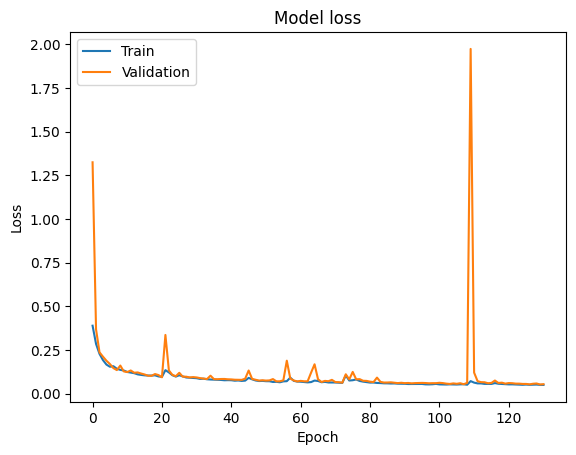

KeyError: 'val_epoch'

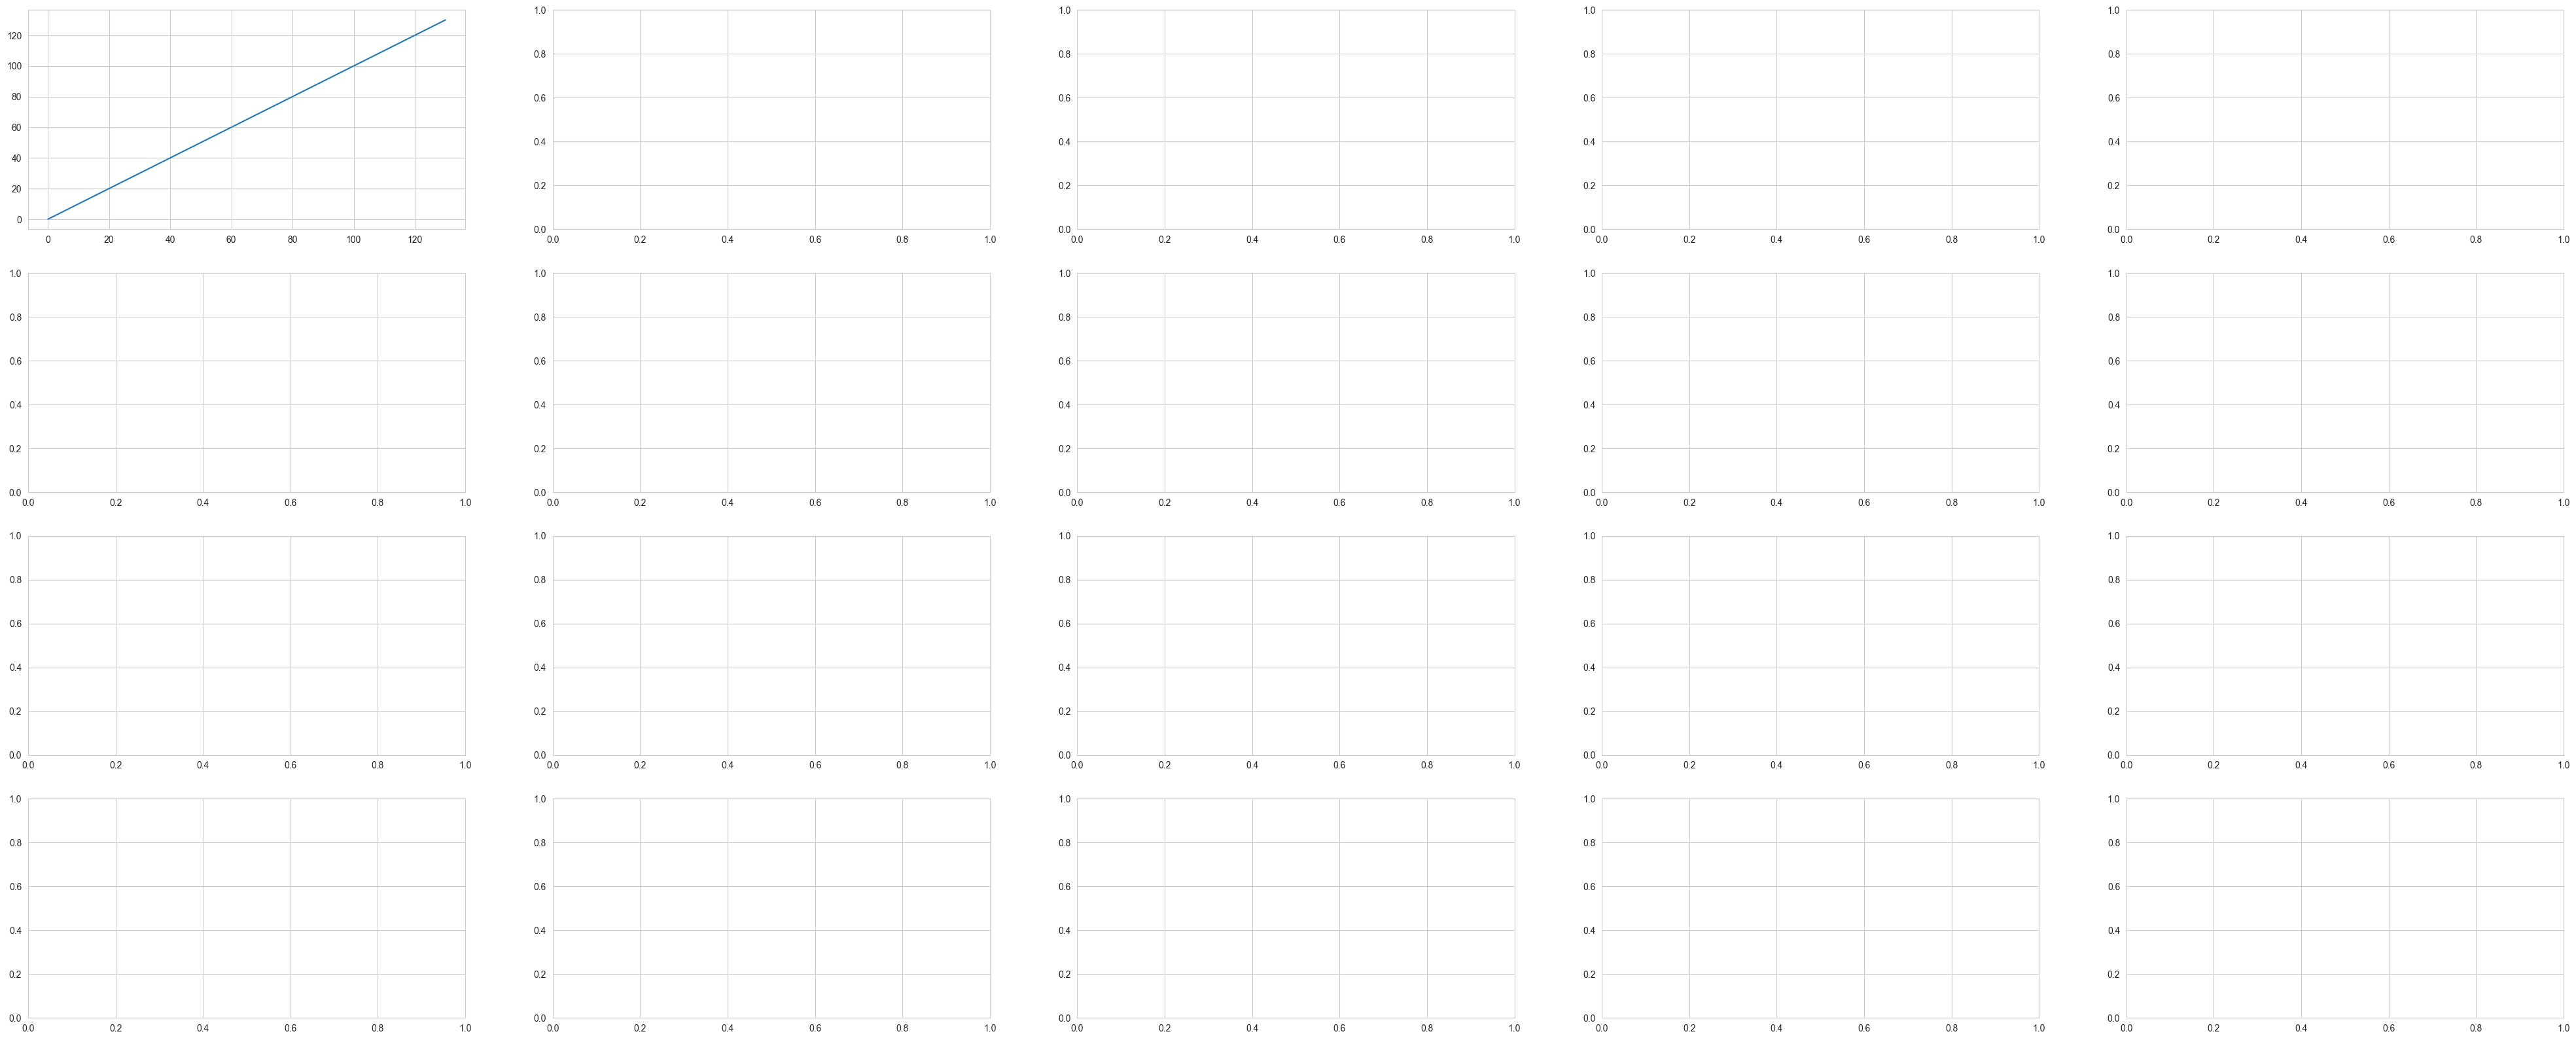

In [29]:
import utils.visualization
importlib.reload(utils.visualization)
from utils.visualization import plot_history, plot_loss
plot_loss(model_history, path='../results/'+config['model_name']+'/' + 'loss_history.png', log=False)
plot_history(model_history, path='../results/'+config['model_name']+'/' + 'metrics_history.png', figsize=(50,20))

## Predictions

In [30]:
from utils.visualization import plot_multitask
# To plot the pre-processed data we can use our custom test generator with batch_size equal to 1
test_plot_generator = MultiTaskGenerator(ids=test_ids, loader=rodent_dataset, batch_size=1, preprocessor=preprocessor, config=config, shuffle=True)
for index in range(len(test_plot_generator))[:15]:
    plot_multitask(val_ids, index, test_plot_generator, model)

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (80, 80, 80)
- Batch size: 1
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

1/1 [==============================] - 5s 5s/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_150_5M')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 58ms/step
ID: ('T2w-C52-RARE', 'TBI_gv_20_68')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 42ms/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_166_5W')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 42ms/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_169_5M')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 47ms/step
ID: ('T2w-C52-RARE', 'TBI_gv_20_86')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 43ms/step
ID: ('T2w-Caen\\3 weeks', '20240917_100208_LS_TBI_J21_C2S4_170924_1_1')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 31ms/step
ID: ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 44ms/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_153_5M')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 41ms/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_133_5M')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 40ms/step
ID: ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1809')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 41ms/step
ID: ('T2w-C52-RARE', 'TBI_gv_17_51')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 35ms/step
ID: ('T1w-CD1-FLASH', 'TBI_PTE_fm_20_170')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 49ms/step
ID: ('T1w-C52-FLASH', 'TBI_MC_fp_22_146_5M')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 40ms/step
ID: ('T2w-C52-RARE', 'TBI_gv_20_19')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

1/1 [==============================] - 0s 52ms/step
ID: ('T2w-C52-RARE', 'TBI_gv_17_57')


interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=39, description='SLICE', max=79), Output()), _dom_classes=('widget-inter…

ID:  ('T1w-CD1-FLASH', 'TBI_PTE_fm_20_175')


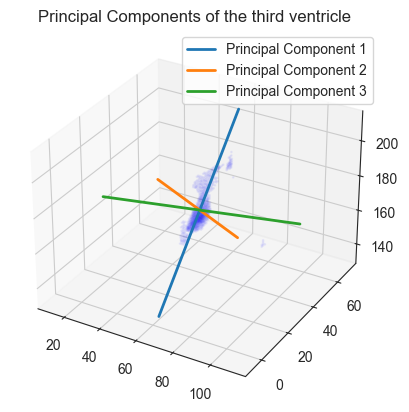

interactive(children=(IntSlider(value=149, description='SLICE', max=299), Output()), _dom_classes=('widget-int…

In [ ]:
import evaluation.inference
import importlib
import numpy as np
from evaluation.inference import RandomCroppingPrediction
from evaluation.postprocessing import ipsi_contra_division_callback

# Take a random id from the validation set tuple
id = test_ids[1]
print("ID: ", id)

# Preprocessor
inferenceProcessor = Preprocessor([
    CorrectX10(),
    MapLabels(labels=config['labels']),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Reorient(ref_img),
    Normalize(),
    Flip(axis_list=[0], probability=1),
])

# Get mouse object from loader
mouse = rodent_dataset.get_subject(id)

# Extract images and masks
image, roi_ground_truth, brain_mask_ground_truth = mouse.get_images()

# Preprocess and augment the images
prep_image = inferenceProcessor.preprocess(image)

# Predict regions and brain mask
predictor = RandomCroppingPrediction(model, patch_size=config['input_shape'], stride=32, threshold=0.5, num_classes=config['num_classes'])
results = predictor.random_cropping_inference(prep_image, with_brain_mask=True)
Y_pred = results['roi']
y_mask = results['brain_mask']

# Post processing
Y_pred = ipsi_contra_division_callback(visualize_pca=True, use_centroids=False)(Y_pred)

# Explore the final roi mask
explore_3D_overlay(arr_before=np.rot90(prep_image.get_fdata(), k=-1), mask=np.rot90(Y_pred, k=-1), axis=-1)


# 10. Evaluation <a class='anchor' id='eval'></a> [↑](#top)

In [34]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
from tabulate import tabulate
from utils.utils import save_metrics, save_model_info

# Print test
print(test_ids)
# Save metrics, model info, and augmentation info
print("Model name: ", config['model_name'])
save_metrics(results, model, path=f'../results/{config["model_name"]}/metrics.txt')
save_model_info(model, config, filters, test_ids, path=f'../results/{config["model_name"]}/model_info.txt')
augmented.save_configuration(path=f'../results/{config["model_name"]}/augmentation_config.txt')
preprocessor.save_configuration(path=f'../results/{config["model_name"]}/preprocessor_config.txt')

[('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T2w-C52-RARE', 'TBI_gv_20_69'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T2w-C52-RARE', 'TBI_gv_20_69'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_

# 11. Full volume evaluation <a class='anchor' id='eval'></a> [↑](#top)

Unique test ids for modality T1w-C52-FLASH:
 - [('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1817'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1793'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_132_5M'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1785'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_130_5M'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1777')]
Unique test ids for modality T1w-CD1-FLASH:
 - [('T1w-CD1-FLASH', 'TBI_PTE_fm_20_175')]
Unique test ids for modality T2w-C52-RARE:
 - [('T2w-C52-RARE', 'TBI_fm_19_64'), ('T2w-C52-RARE', 'TBI_gv_18_184'), ('T2w-C52-RARE', 'TBI_gv_20_53')]
Unique test ids for modality T2w-Caen\3 weeks:
 - []
Evaluation for stride 20
Evaluation for modality T1w-C52-FLASH
Evaluation for subject Isch_PAL_PPIAKO_1817
Evaluation for subject TBI_AAV_PPIAKO_1793
Evaluation for subject TBI_MC_fp_22_128_5W
Evaluation for subject TBI_MC_fp_22_126_5M
Evaluation for subject TBI_MC_fp_22_132_5M
Evaluation for subject Isch_PAL_PPIAKO_1785

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----------------------+----------+----------+---------------+------------+------------+------------+------------+------------+
| Subject              | Metric   |   Stride | Modality      |   Class: 0 |   Class: 1 |   Class: 2 |   Class: 3 |   Class: 4 |
|----------------------+----------+----------+---------------+------------+------------+------------+------------+------------|
| Isch_PAL_PPIAKO_1777 | dice     |       20 | T1w-C52-FLASH |   0.999618 |   0.964013 |   0.950785 |   0.876052 |   0.951049 |
| Isch_PAL_PPIAKO_1777 | dice     |       40 | T1w-C52-FLASH |   0.999594 |   0.96194  |   0.948122 |   0.875766 |   0.950642 |
| Isch_PAL_PPIAKO_1785 | dice     |       20 | T1w-C52-FLASH |   0.999538 |   0.961247 |   0.971208 |   0.930612 |   0.961051 |
| Isch_PAL_PPIAKO_1785 | dice     |       40 | T1w-C52-FLASH |   0.999542 |   0.962409 |   0.972074 |   0.942491 |   0.959964 |
| Isch_PAL_PPIAKO_1817 | dice     |       40 | T1w-C52-FLASH |   0.999699 |   0.971115 |   0.968461 |   

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----------------------+-------------+----------+---------------+------------+------------+------------+------------+------------+
| Subject              | Metric      |   Stride | Modality      |   Class: 0 |   Class: 1 |   Class: 2 |   Class: 3 |   Class: 4 |
|----------------------+-------------+----------+---------------+------------+------------+------------+------------+------------|
| Isch_PAL_PPIAKO_1777 | sensitivity |       20 | T1w-C52-FLASH |   0.999812 |   0.950333 |   0.942049 |   0.792089 |   0.922538 |
| Isch_PAL_PPIAKO_1777 | sensitivity |       40 | T1w-C52-FLASH |   0.999825 |   0.944179 |   0.936396 |   0.79716  |   0.922976 |
| Isch_PAL_PPIAKO_1785 | sensitivity |       20 | T1w-C52-FLASH |   0.999813 |   0.939175 |   0.96094  |   0.923825 |   0.940331 |
| Isch_PAL_PPIAKO_1785 | sensitivity |       40 | T1w-C52-FLASH |   0.999806 |   0.941912 |   0.96094  |   0.923015 |   0.939895 |
| Isch_PAL_PPIAKO_1817 | sensitivity |       40 | T1w-C52-FLASH |   0.999755 |   0.

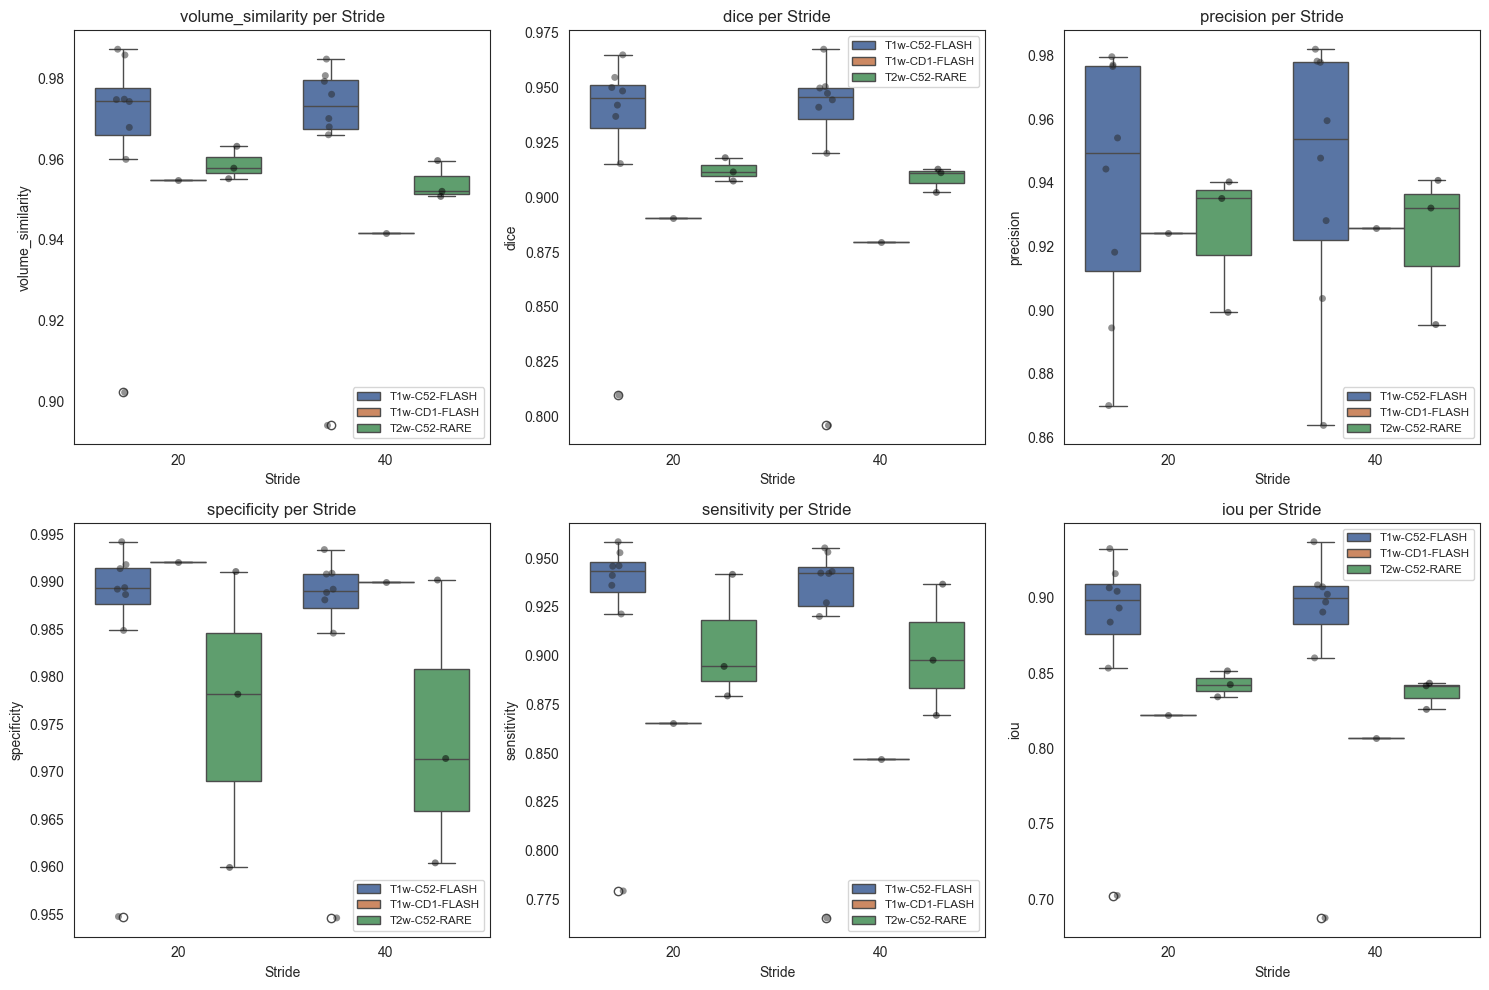

In [35]:
import evaluation.inference
importlib.reload(evaluation.inference)
from evaluation.inference import FullVolumeEvaluation

import evaluation.postprocessing    
importlib.reload(evaluation.postprocessing)
from evaluation.postprocessing import ipsi_contra_division_callback, morphology_refinement_callback

inferenceProcessor = Preprocessor([
    CorrectX10(),
    MapLabels(labels=config['labels']),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Reorient(ref_img),
    Normalize(),
])

full_volume_eval = FullVolumeEvaluation(model, test_ids, config, rodent_dataset, roi_postprocess_callback=ipsi_contra_division_callback(),
                                        strides=[20,40], preprocessor=inferenceProcessor, path='../results/'+config['model_name']+'/', verbose=True)
resu= full_volume_eval.evaluate()

Unique test ids for modality T1w-C52-FLASH:
 - [('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782')]
Unique test ids for modality T1w-CD1-FLASH:
 - []
Unique test ids for modality T2w-C52-RARE:
 - [('T2w-C52-RARE', 'TBI_gv_17_49'), ('T2w-C52-RARE', 'TBI_gv_20_69')]
Unique test ids for modality T2w-RATS:
 - []
Evaluation for stride 20
Evaluation for modality T1w-C52-FLASH
Evaluation for subject TBI_AAV_PPIAKO_1776
Evaluation for subject TBI_MC_fp_22_170_5W
Evaluation for subject Isch_PAL_PPIAKO_1818
Evaluation for subject TBI_AAV_PPIAKO_1811
Evaluation for subject TBI_MC_fp_22_126_5M
Evaluation for subject TBI_MC_fp_22_128_5W
Evaluation for subject Isch_PAL_PPIAKO_1782
dice per subject per class
+----------+----------------------+------------+
| Me

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----------------------+-------------+----------+---------------+------------+
| Subject              | Metric      |   Stride | Modality      |   Class: 0 |
|----------------------+-------------+----------+---------------+------------|
| Isch_PAL_PPIAKO_1782 | sensitivity |       20 | T1w-C52-FLASH |   0.995817 |
| Isch_PAL_PPIAKO_1782 | sensitivity |       40 | T1w-C52-FLASH |   0.995434 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       40 | T1w-C52-FLASH |   0.994077 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       20 | T1w-C52-FLASH |   0.993446 |
| TBI_AAV_PPIAKO_1776  | sensitivity |       40 | T1w-C52-FLASH |   0.995091 |
| TBI_AAV_PPIAKO_1776  | sensitivity |       20 | T1w-C52-FLASH |   0.995021 |
| TBI_AAV_PPIAKO_1811  | sensitivity |       20 | T1w-C52-FLASH |   0.980229 |
| TBI_AAV_PPIAKO_1811  | sensitivity |       40 | T1w-C52-FLASH |   0.98048  |
| TBI_MC_fp_22_126_5M  | sensitivity |       40 | T1w-C52-FLASH |   0.97524  |
| TBI_MC_fp_22_126_5M  | sensitivity |       20 | T1

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----+----------------------+-------------------+----------+---------------+------------+----------+
|    | Subject              | Metric            |   Stride | Modality      |   Class: 0 |     Mean |
|----+----------------------+-------------------+----------+---------------+------------+----------|
|  0 | Isch_PAL_PPIAKO_1782 | dice              |       20 | T1w-C52-FLASH |   0.993475 | 0.993475 |
|  1 | Isch_PAL_PPIAKO_1782 | dice              |       40 | T1w-C52-FLASH |   0.993131 | 0.993131 |
|  2 | Isch_PAL_PPIAKO_1818 | dice              |       20 | T1w-C52-FLASH |   0.992201 | 0.992201 |
|  3 | Isch_PAL_PPIAKO_1818 | dice              |       40 | T1w-C52-FLASH |   0.992553 | 0.992553 |
|  4 | TBI_AAV_PPIAKO_1776  | dice              |       40 | T1w-C52-FLASH |   0.992837 | 0.992837 |
|  5 | TBI_AAV_PPIAKO_1776  | dice              |       20 | T1w-C52-FLASH |   0.992887 | 0.992887 |
|  6 | TBI_AAV_PPIAKO_1811  | dice              |       20 | T1w-C52-FLASH |   0.985413 | 0

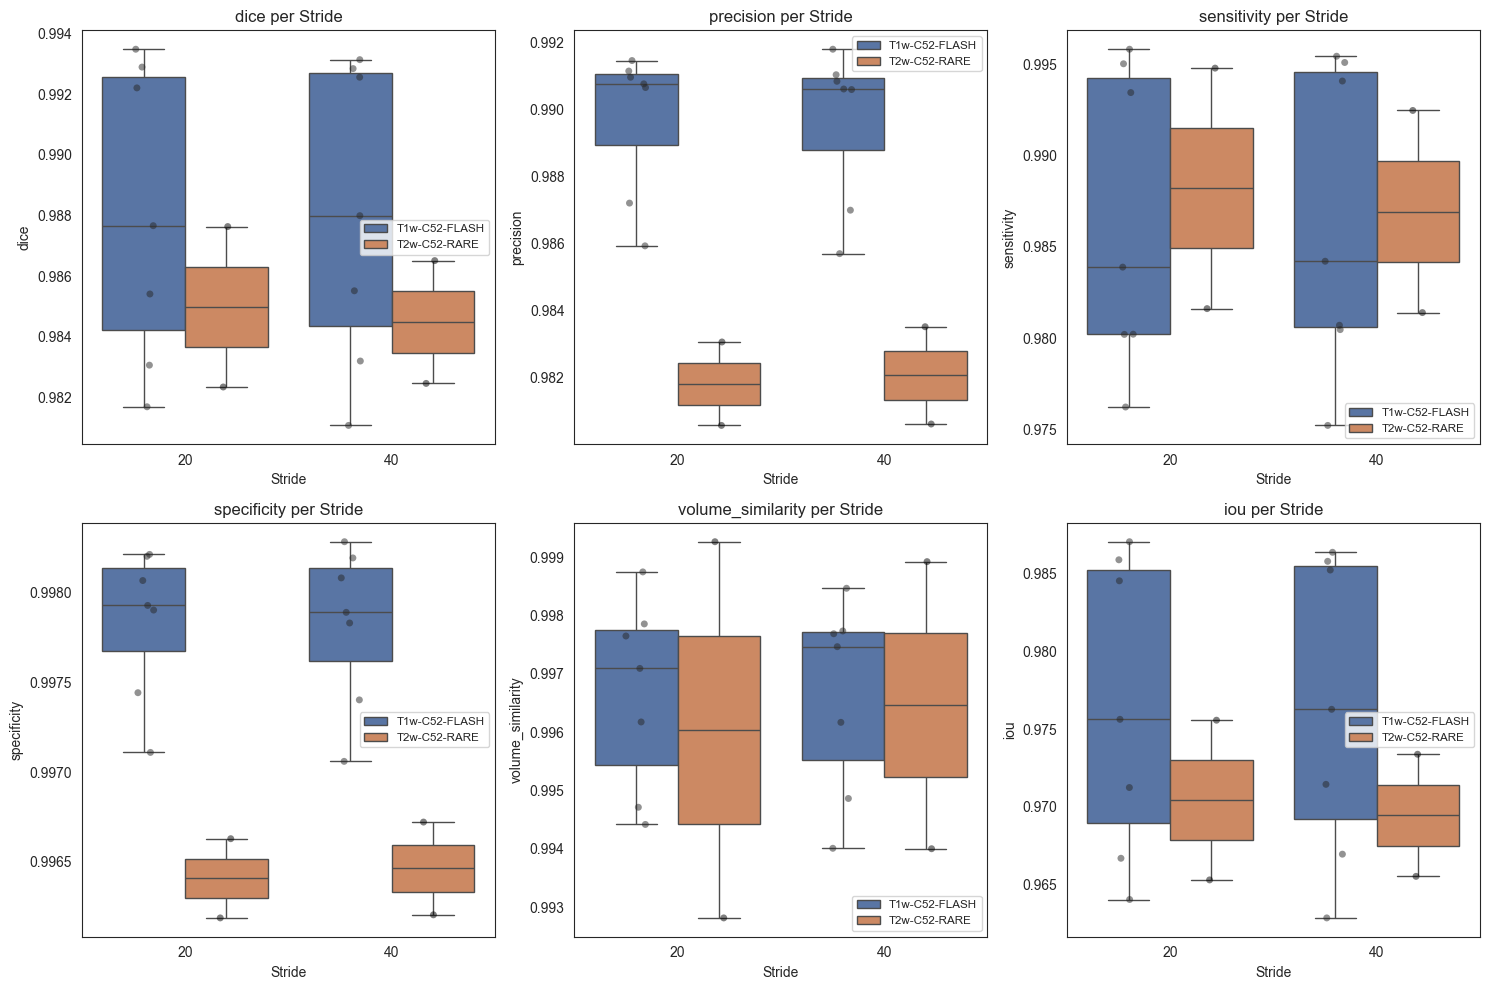

In [ ]:
full_volume_eval = FullVolumeEvaluation(model, test_ids, config, rodent_dataset, strides=[20,40], preprocessor=inferenceProcessor, 
                                        brain_mask_postprocess_callback=morphology_refinement_callback(), path='../results/'+config['model_name']+'/', verbose=True)
resu= full_volume_eval.evaluate(evaluate_brain_mask=True)